# Exam 01-07-2022

In [32]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy.stats as sc
import sys
sys.path.append('/home/gio/Desktop/LaboratorioCalcoloEStatistica')
from mylib.basics import sturges

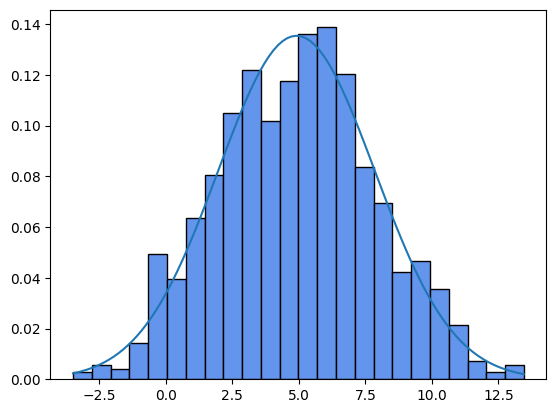

In [33]:
def gauss_TAC(size,m,s):
    a,b = m - 3*s, m+3*s
    count = 0
    gauss = np.empty(size,dtype=np.float64)
    while count < size:
        x = a + np.random.rand()*(b-a)
        y = np.random.rand()
        if y <= sc.norm.pdf(x,m,s):
            gauss[count] = x
            count += 1
    return gauss

data = gauss_TAC(1000,5,3)
plt.hist(data,density=True,edgecolor='black',color='cornflowerblue',bins=sturges(1000))
x = np.linspace(min(data),max(data),100)
plt.plot(x,sc.norm.pdf(x,np.mean(data),np.std(data)))
plt.show()

In [53]:
from iminuit import Minuit
from iminuit.cost import LeastSquares,BinnedNLL
from mylib.integrals import crude_montecarlo

In [55]:
N = 1000
data = gauss_TAC(N,5,3)
bin_edges = np.linspace(np.min(data),np.max(data),sturges(N))
bin_content = np.array([len(data[(data>i)*(data<=g)]) for i,g in zip(bin_edges[:-1],bin_edges[1:])])
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])

In [56]:
m,s = np.mean(data),np.std(data)
interval = (np.max(data)-np.min(data))/sturges(N)
pdf = lambda x,m,s: N*interval*sc.norm.pdf(x,m,s)
# print(bin_content/N,sc.norm.pdf(bin_centres,m,s))
yerr = np.sqrt(np.sum((bin_content-N*interval*sc.norm.pdf(bin_centres,m,s)*2)**2)/(N-1))
least_squares = LeastSquares(bin_centres, bin_content, yerr, pdf)
my_minuit = Minuit(least_squares, m = m, s = s)  # starting values for t1 and t2
my_minuit.migrad()  # finds minimum of least_squares function
my_minuit.hesse()   # accurately computes uncertainties
display(my_minuit)

# x = np.linspace(np.min(data),np.max(data),100)
# plt.hist(data,bins=sturges(N),color='palegreen',edgecolor='black')
# plt.plot(x,pdf(x,np.mean(data),np.std(data)))
# plt.show()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.4 (χ²/ndof = 1.1)       │              Nfcn = 32               │
│ EDM = 6.91e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   5.05    │   0.12    │            │            │         │         │       │
│ 1 │ s    │   2.85    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      m      s │
├───┼───────────────┤
│ m │ 0.0153 -0.000 │
│ s │ -0.000 0.0101 │
└───┴───────────────┘

In [58]:
def mod_total_bin (bin_edges, m, s):
    return sc.norm.cdf(bin_edges, m, s)

my_cost_func_bin = BinnedNLL(bin_content, bin_edges, mod_total_bin)

binned_minuit = Minuit (my_cost_func_bin, m=m, s=s)
binned_minuit.migrad()
display(binned_minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 34.28 (χ²/ndof = 1.6)      │              Nfcn = 24               │
│ EDM = 4.6e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   5.04    │   0.09    │            │            │         │         │       │
│ 1 │ s    │   2.86    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       s │
├───┼─────────────────┤
│ m │  0.0082   0.000 │
│ s │   0.000 0.00412 │
└───┴─────────────────┘

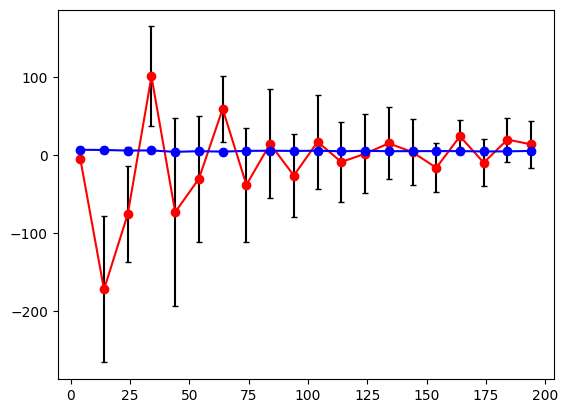

In [76]:
start,stop,step = 4,200,10
X = range(start,stop,step)
size = len(X)
qm = np.empty(size,dtype=np.float64)
qs = np.empty(size,dtype=np.float64)
Lm = np.empty(size,dtype=np.float64)
Ls = np.empty(size,dtype=np.float64)

binned_cdf = lambda x, m, s: sc.norm.cdf(x, m, s)
q_pdf = lambda x,m,s: N*interval*sc.norm.pdf(x,m,s)

for k in X:
    data = np.random.normal(5,4,size=k)
    bin_edges = np.linspace(np.min(data),np.max(data),sturges(N))
    bin_content = np.array([len(data[(data>i)*(data<=g)]) for i,g in zip(bin_edges[:-1],bin_edges[1:])])
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    yerr = np.sqrt(np.sum((bin_content-N*interval*sc.norm.pdf(bin_centres,m,s)*2)**2)/(N-1))
    least_squares = LeastSquares(bin_centres, bin_content, yerr, q_pdf)
    ls = Minuit(least_squares, m = m, s = s)  # starting values for t1 and t2
    ls.migrad()  # finds minimum of least_squares function
    qm[X.index(k)] = ls.values['m']
    qs[X.index(k)] = ls.values['s']

    binned_nll = BinnedNLL(bin_content, bin_edges, binned_cdf)
    bl = Minuit(binned_nll, m=m, s=s)
    bl.migrad()
    Lm[X.index(k)] = bl.values['m']
    Ls[X.index(k)] = bl.values['s']

plt.errorbar(X,qm,qs,fmt='o-',color='red',capsize=2,ecolor='black')
plt.errorbar(X,Lm,Ls,fmt='o-',color='blue',capsize=2,ecolor='black')
plt.show()
    